In [1]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
import numpy as np
from numpy import array
from numpy import hstack
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
import collections
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)
plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

!pip install -q keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
drive.ListFile({'q': "'1EYL1Xky9v3LygcLztNjbxlpbc2RFmyon' in parents and trashed=false"}).GetList()
data_downloaded=drive.CreateFile({'id': '1AcUHDj2sdcehV5aTv-34GNc9Lo7_5-Tm'})
data_downloaded.GetContentFile('Metro_Interstate_Traffic_Volume.csv')

In [3]:
data=pd.read_csv('Metro_Interstate_Traffic_Volume.csv',low_memory=False, lineterminator='\n')
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume\r
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
df=data
df['date_time'] = pd.to_datetime(df.date_time)
df['year'] = df.date_time.dt.year
df=df.drop(['holiday','weather_main','weather_description','snow_1h','clouds_all','date_time'],axis='columns') #deja rain, traffic volume, temp y year
df.head()

,temp,rain_1h,traffic_volume\r,year
0,288.28,0.0,5545,2012
1,289.36,0.0,4516,2012
2,289.58,0.0,4767,2012
3,290.13,0.0,5026,2012
4,291.14,0.0,4918,2012


In [9]:
df_train=df[df['year']==2016]
df_train=df_train.drop(['year'],axis='columns')
df_train.shape

(9306, 3)

In [6]:
df_validation=df[df['year']==2017]
df_validation=df_validation.drop(['year'],axis='columns')
df_validation.shape

(10605, 3)

In [7]:
df_test=df[df['year']==2018]
df_test=df_test.drop(['year'],axis='columns')
df_test.shape

(7949, 3)

In [10]:
###########################################
stack1=df_train.drop(['traffic_volume\r','temp'],axis='columns') #rain_1h
stack2=df_train.drop(['rain_1h','temp'],axis='columns') #traffic_volume
stack3=df_train.drop(['rain_1h','traffic_volume\r'],axis='columns') #temp
df_train=hstack((stack1, stack3, stack3))
df_train.shape

(9306, 3)

In [11]:
########################################### 
stack1=df_validation.drop(['traffic_volume\r','temp'],axis='columns') #rain_1h
stack2=df_validation.drop(['rain_1h','temp'],axis='columns') #traffic_volume
stack3=df_validation.drop(['rain_1h','traffic_volume\r'],axis='columns') #temp
df_validation=hstack((stack1, stack3, stack2))
df_validation.shape

(10605, 3)

In [12]:
###########################################
stack1=df_test.drop(['traffic_volume\r','temp'],axis='columns') #rain_1h
stack2=df_test.drop(['rain_1h','temp'],axis='columns') #traffic_volume
stack3=df_test.drop(['rain_1h','traffic_volume\r'],axis='columns') #temp
df_test=hstack((stack1, stack3, stack2))
df_test.shape

(7949, 3)

In [0]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [0]:
#720 = 30 dias
x_train, y_train = split_sequence(df_train, 2160)
x_val, y_val = split_sequence(df_validation, 2160)

In [15]:
x_train=x_train.reshape((x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
x_train.shape

(7146, 4320)

In [16]:
x_val=x_val.reshape((x_val.shape[0],x_val.shape[1]*x_val.shape[2]))
x_val.shape

(8445, 4320)

In [17]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               432100    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 432,201
Trainable params: 432,201
Non-trainable params: 0
_________________________________________________________________


In [47]:
# fit model
history = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=500, verbose=1)

Epoch 1/500
224/224 [==============================] - 2s 8ms/step - loss: 7.1569 - mae: 2.1294 - val_loss: 13484734.0000 - val_mae: 3087.2739
Epoch 2/500
224/224 [==============================] - 2s 7ms/step - loss: 8.0338 - mae: 2.2554 - val_loss: 13477396.0000 - val_mae: 3086.1208
Epoch 3/500
224/224 [==============================] - 2s 8ms/step - loss: 8.0294 - mae: 2.2452 - val_loss: 13480298.0000 - val_mae: 3086.5784
Epoch 4/500
224/224 [==============================] - 2s 8ms/step - loss: 7.1635 - mae: 2.1198 - val_loss: 13471338.0000 - val_mae: 3085.1697
Epoch 5/500
224/224 [==============================] - 2s 7ms/step - loss: 8.4711 - mae: 2.3159 - val_loss: 13485574.0000 - val_mae: 3087.4055
Epoch 6/500
224/224 [==============================] - 2s 8ms/step - loss: 9.6870 - mae: 2.5113 - val_loss: 13489609.0000 - val_mae: 3088.0388
Epoch 7/500
224/224 [==============================] - 2s 7ms/step - loss: 8.4445 - mae: 2.3331 - val_loss: 13480758.0000 - val_mae: 3086.6482

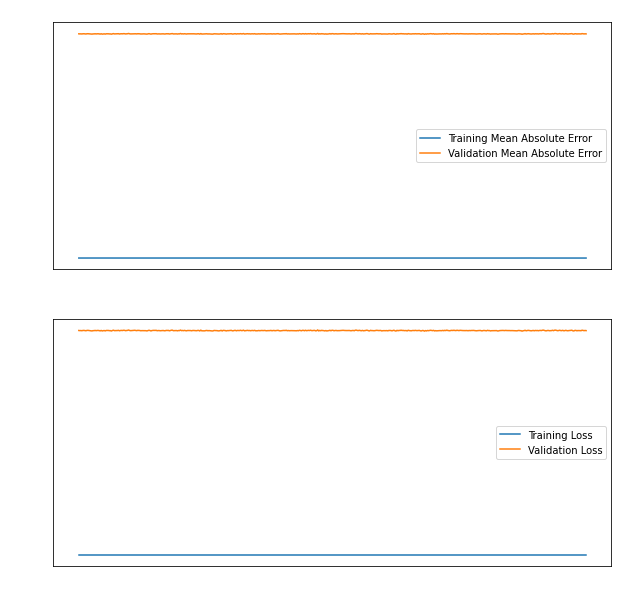

In [48]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training Mean Absolute Error')
plt.plot(val_mae, label='Validation Mean Absolute Error')
plt.legend(loc='lower right')
plt.setp(plt.legend().get_texts(), color='black')
plt.ylabel('Mean Absolute Error')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Mean Absolute Error')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.setp(plt.legend().get_texts(), color='black')
plt.ylabel('Cross Entropy')
plt.ylim(min(plt.ylim()),max(plt.ylim()))
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
# demonstrate prediction
x_test, y_test = split_sequence(df_test, 2160)
x_t=x_test[0]
x_t=x_t.reshape((1,x_test.shape[1]*x_test.shape[2]))
y_t=y_test[0]
y_t=y_t.reshape((1,1))

In [50]:
preds = model.predict(x_t, verbose=0)
print("Real: %d\nPrediccion: %d" % (y_t,preds))

Real: 1642
Prediccion: 275


In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_t, preds))
print("RMSE: %d" % (rmse))

RMSE: 1366
